In [1]:
import tweepy
import csv
import pandas as pd
import numpy as np
import string
import re
import nltk
import Sastrawi
import ast
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from tweepy import OAuthHandler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection

In [2]:
api_key = "qubRP6d5B5eCD3RHrgoMRkDjH"
api_secret_key = "AJlk1MiHfXqnhByWtCf1Mbi2T9WGW08hoLkkDIbks4ztUpFx99"
access_token ="3180202308-DmrgiSoxUUoSRevLLPldgCE57M0eD117K0mhFG5"
access_token_secret = "fuY5Hkk838OnmGOZUb16KLkSDw3JZjflxXQ1NHP6pP9Jr"

In [3]:
auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret) 
API = tweepy.API(auth, wait_on_rate_limit = False)

In [4]:
posts = tweepy.Cursor(API.search_tweets, q='shopeefood -filter:retweets', tweet_mode='extended',lang="id").items(100)
users = [[tweet.created_at, tweet.full_text] for tweet in posts]
users

[[datetime.datetime(2021, 11, 20, 9, 30, 36, tzinfo=datetime.timezone.utc),
  '@ShopeeCare @ShopeeID hallo min saya ingin mengkomplain mengenai shopeefood, yang saya tangkap ternyata driver membawa pergi makanan yang sudah saya pesan (saya sudah membayar melalui shopee pay)'],
 [datetime.datetime(2021, 11, 20, 9, 29, 14, tzinfo=datetime.timezone.utc),
  'pngn shopeefood tp gue kasian sm abangnya. kejauhan soalnya. resiko tinggal d kampung'],
 [datetime.datetime(2021, 11, 20, 9, 26, 59, tzinfo=datetime.timezone.utc),
  'Bestnya guna shopeefood, free delivery voucher dengan discount voucher boleh guna serentak. Save banyak woooo..'],
 [datetime.datetime(2021, 11, 20, 9, 22, 30, tzinfo=datetime.timezone.utc),
  'hawa nya tu bikin pengen buka shopeefood mulu:) wkwk'],
 [datetime.datetime(2021, 11, 20, 8, 57, 24, tzinfo=datetime.timezone.utc),
  'Pasuruan udah ada shopeefood yeay'],
 [datetime.datetime(2021, 11, 20, 8, 55, 59, tzinfo=datetime.timezone.utc),
  'beli lotek 3 bungkus + 1 bungk

In [5]:
df = pd.DataFrame(data=users, columns=['Created_At','Tweets'])

In [7]:
df.head()

,Created_At,Tweets
0,2021-11-20 09:30:36+00:00,@ShopeeCare @ShopeeID hallo min saya ingin men...
1,2021-11-20 09:29:14+00:00,pngn shopeefood tp gue kasian sm abangnya. kej...
2,2021-11-20 09:26:59+00:00,"Bestnya guna shopeefood, free delivery voucher..."
3,2021-11-20 09:22:30+00:00,hawa nya tu bikin pengen buka shopeefood mulu:...
4,2021-11-20 08:57:24+00:00,Pasuruan udah ada shopeefood yeay


In [24]:
def remove(tweet):
    
    #case folding tweet
    tweet = tweet.lower()
    
    #remove one char
    tweet = re.sub(r"\b[a-zA-Z]\b", "", tweet)

    #remove angka
    tweet = re.sub('[0-9]+', '', tweet)
    
    # remove tab, new line, ans back slice
    tweet = tweet.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
 
    # remove non ASCII (emoticon, chinese word, .etc)
    tweet = tweet.encode('ascii', 'replace').decode('ascii')
    
    # remove mention, link, hashtag
    tweet = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", tweet).split())

    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    #remove punctuation
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    
    #remove whitespace leading & trailing
    tweet = tweet.strip()
    
    #remove multiple whitespace into single whitespace
    tweet = re.sub('\s+',' ',tweet)

    return tweet

df['Clean_Data'] = df['Tweets'].apply(remove)

In [25]:
normalized_word = pd.read_csv('Kamus_Baku-copy1.csv')

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return ' '.join([normalized_word_dict[term] if term in normalized_word_dict else term for term in document.split()])

df['Tweet_Normal'] = df['Clean_Data'].apply(normalized_term)

In [26]:
stop_words=stopwords.words('indonesian')
stop_words.extend(["yg", "dg", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh',
                       '&amp', 'yah', 'klau', 'a', 'b', 'c', 'd', 'e', 'f',
                   'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 
                   's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

df.columns = ['Created_At', 'Tweets', 'Clean_Data', 'Tweet_Normal']

df['Tanpa_StopWords'] = df['Tweet_Normal'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [27]:
stop_words=stopwords.words('english')
df['Tanpa_StopWords'] = df['Tanpa_StopWords'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [28]:
df['Tokenizing'] = df['Tanpa_StopWords'].apply(word_tokenize)

In [34]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

df['Stemming'] = df['Tokenizing'].dropna().apply(lambda x : ([stemmer.stem(y) for y in x]))

In [36]:
word_dict = {}
for i in range(0,len(df['Stemming'])):
    sentence = df['Stemming'][i]
    for j in sentence:
        if j not in word_dict:
            word_dict[j] = 1
        else:
            word_dict[j] += 1

In [37]:
negasi = ['bukan','tidak','ga','gk']
lexicon = pd.read_csv('full_lexicon-Copy1.csv')
lexicon = lexicon.drop(lexicon[(lexicon['word'] == 'bukan')
                               |(lexicon['word'] == 'tidak')
                               |(lexicon['word'] == 'ga')|(lexicon['word'] == 'gk') ].index,axis=0)
lexicon = lexicon.reset_index(drop=True)

In [38]:
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']

ns_words = []

for word in word_dict.keys():
    if word not in lexicon_word:
        kata_dasar = stemmer.stem(word)
        if kata_dasar not in lexicon_word:
            ns_words.append(word)

In [39]:
sencol =[]
senrow =np.array([])
nsen = 0

sentiment_list = []
# function to write the word's sentiment if it is founded
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # if it is already included in the bag of words matrix, then just increase the value
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    #if not, than add new word
        sencol.append(word)
        sen.append(1)
        add += 1
    #if there is a negation word before it, the sentiment would be the negation of it's sentiment
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add
            
# checking every words, if they are appear in the lexicon, and then calculate their sentiment if they do
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = df['Stemming'][i]
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # check whether they are included in the lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
        # if not, then check the root word
            kata_dasar = stemmer.stem(word)
            if kata_dasar in lexicon_word:
                sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # if still negative, try to match the combination of words with the adjacent words
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [40]:
sencol.append('Bobot')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)

In [41]:
cek_df = pd.DataFrame([])
cek_df['Tweetnya'] = df['Stemming'].copy()
cek_df['Bobot']  = df_sen['Bobot'].copy()
cek_df

,Tweetnya,Bobot
0,"[id, orang, lihat, review, adu, atuh, orang, g...",2
1,"[kota, enak, makan, sana, ujung, shopeefood, m...",6
2,"[alih, shopeefood, vouchernya, nagih]",0
3,"[bestie, mas, mas, shopeefood]",0
4,"[mari, jelajah, grabfood, gofood, shopeefood]",4
...,...,...
495,"[hi, kak, maaf, banget, kak, kait, kendala, me...",4
496,"[shopeefood, berkah, voucher, grabfood, ngadi,...",7
497,"[moga, diskon, grabfood, shopeefood, ena, jaja...",6
498,"[voucher, shopeefood, linknya]",3


In [42]:
df['Bobot'] = df_sen['Bobot']

In [43]:
df.loc[df['Bobot'] == 0, 'Label'] = 'netral'
df.loc[df['Bobot'] > 0, 'Label'] = 'positif'
df.loc[df['Bobot'] < 0, 'Label'] = 'negatif'
df['Label'].value_counts()

positif    330
negatif     91
netral      79
Name: Label, dtype: int64

In [44]:
df.loc[cek_df['Bobot'] == 0, 'Sentimen'] = 2 #netral
df.loc[cek_df['Bobot'] > 0, 'Sentimen'] = 1 #positive
df.loc[cek_df['Bobot'] < 0, 'Sentimen'] = 0 #negative

In [45]:
df

,Created_At,Tweets,Clean_Data,Tweet_Normal,Tanpa_StopWords,Tokenizing,Stemming,Bobot,Label,Sentimen
0,2021-11-19 11:37:25+00:00,@mchmmdzola @shopeefood_id Orang ga bisa liat ...,id orang ga bisa liat review atau pengaduan ka...,id orang tidak bisa lihat review atau pengadua...,id orang lihat review pengaduan atuh orang gem...,"[id, orang, lihat, review, pengaduan, atuh, or...","[id, orang, lihat, review, adu, atuh, orang, g...",2,positif,1.0
1,2021-11-19 11:37:07+00:00,emang kalo di Kota besar kaya gini paling ga e...,emang kalo di kota besar kaya gini paling ga e...,memang kalau di kota besar seperti begini pali...,kota enak makan disana ujungnya shopeefood moo...,"[kota, enak, makan, disana, ujungnya, shopeefo...","[kota, enak, makan, sana, ujung, shopeefood, m...",6,positif,1.0
2,2021-11-19 11:36:10+00:00,"@ashisicha Gue beralih ke ShopeeFood sekarang,...",gue beralih ke shopeefood sekarang vouchernya ...,saya beralih ke shopeefood sekarang vouchernya...,beralih shopeefood vouchernya nagih,"[beralih, shopeefood, vouchernya, nagih]","[alih, shopeefood, vouchernya, nagih]",0,netral,2.0
3,2021-11-19 11:32:22+00:00,Seperti sudah bestie sekali dengan mas mas sho...,seperti sudah bestie sekali dengan mas mas sho...,seperti sudah bestie sekali dengan mas mas sho...,bestie mas mas shopeefood,"[bestie, mas, mas, shopeefood]","[bestie, mas, mas, shopeefood]",0,netral,2.0
4,2021-11-19 11:23:53+00:00,"Mari berjelajah grabfood, gofood, shopeefood :”",mari berjelajah grabfood gofood shopeefood,mari berjelajah grabfood gofood shopeefood,mari berjelajah grabfood gofood shopeefood,"[mari, berjelajah, grabfood, gofood, shopeefood]","[mari, jelajah, grabfood, gofood, shopeefood]",4,positif,1.0
...,...,...,...,...,...,...,...,...,...,...
495,2021-11-17 08:47:57+00:00,"@yoanluvyona Hi Kak, Maaf banget ya Kak terkai...",hi kak maaf banget ya kak terkait kendala tida...,hi kak maaf banget ya kak terkait kendala tida...,hi kak maaf banget kak terkait kendala pemesan...,"[hi, kak, maaf, banget, kak, terkait, kendala,...","[hi, kak, maaf, banget, kak, kait, kendala, me...",4,positif,1.0
496,2021-11-17 08:47:06+00:00,shopeefood adalah berkah ketika voucher grabfo...,shopeefood adalah berkah ketika voucher grabfo...,shopeefood adalah berkah ketika voucher grabfo...,shopeefood berkah voucher grabfood ngadi ngadi,"[shopeefood, berkah, voucher, grabfood, ngadi,...","[shopeefood, berkah, voucher, grabfood, ngadi,...",7,positif,1.0
497,2021-11-17 08:36:55+00:00,Semoga perdiskonan grabfood dan shopeefood sel...,semoga perdiskonan grabfood dan shopeefood sel...,semoga perdiskonan grabfood dan shopeefood sel...,semoga perdiskonan grabfood shopeefood ena jaj...,"[semoga, perdiskonan, grabfood, shopeefood, en...","[moga, diskon, grabfood, shopeefood, ena, jaja...",6,positif,1.0
498,2021-11-17 08:29:24+00:00,VOUCHER SHOPEEFOOD ⚡\n\nini linknya : https://...,voucher shopeefood ini linknya,voucher shopeefood ini linknya,voucher shopeefood linknya,"[voucher, shopeefood, linknya]","[voucher, shopeefood, linknya]",3,positif,1.0


In [56]:
df['Stemming'] = [" ".join(review) for review in df['Stemming'].values]

In [57]:
x_train, x_test, y_train, y_test = train_test_split(df['Stemming'], df['Label'], test_size=0.1, random_state=0)

train_df = pd.DataFrame()
train_df['Stemming'] = x_train
train_df['Label'] = y_train
test_df = pd.DataFrame()
test_df['Stemming'] = x_test
test_df['Label'] = y_test

In [48]:
test_df

,Stemming,Label
90,"[ayo, ready, pesan, yukk, via, gofood, grabfoo...",positif
254,"[promo, traktir, sultan, nanti, merchant, kala...",negatif
283,"[kali, kesandung, shopeepay, pesan, shopeefood...",positif
445,"[cari, pacar, effort, mending, buka, shopeefood]",positif
461,"[benar, cinta, shopeefood, lumayan, banget]",positif
15,"[iya, mending, shopeefood]",positif
316,"[grab, gofood, pelit, promo, voucher, untung, ...",positif
489,"[shopeefood, nolong]",netral
159,"[set, kompor, high, preasure, serta, wajan, ri...",positif
153,"[id, traktir, minimal, haha]",negatif


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy(doc):
    return doc

tfidf = TfidfVectorizer(tokenizer=dummy,preprocessor=dummy)  

docs = df['Stemming']

x = tfidf.fit(docs)

x_train_tfidf = x.transform(x_train)
x_test_tfidf = x.transform(x_test)

C:\Users\HP\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [62]:
clf = svm.SVC(kernel='linear', probability=True)
clf.fit(x_train_tfidf, y_train)

SVC(kernel='linear', probability=True)

In [63]:
y_pred = clf.fit(x_train_tfidf, y_train).predict(x_test_tfidf)
cm = metrics.confusion_matrix(y_test, y_pred)

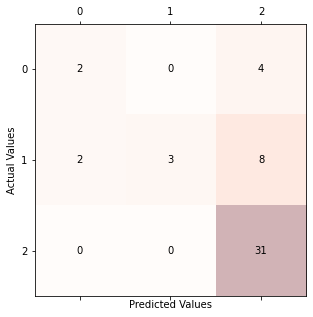

              precision    recall  f1-score   support

     negatif       0.50      0.33      0.40         6
      netral       1.00      0.23      0.38        13
     positif       0.72      1.00      0.84        31

    accuracy                           0.72        50
   macro avg       0.74      0.52      0.54        50
weighted avg       0.77      0.72      0.66        50



In [64]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import Image, display

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()
print(classification_report(y_test, y_pred ))

In [66]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, x_train_tfidf, y_train, cv = 10)
rerata_akurasi_svm = sum(scores)/len(scores)
print("   Rerata akurasi           :",rerata_akurasi_svm)
print("   Rerata akurasi (round)   :",round(rerata_akurasi_svm,2))
dic1 = {"iterasi ke-":[x+1 for x in range(10)], "akurasi":scores}
pd.DataFrame.from_dict(dic1)

   Rerata akurasi           : 0.7044444444444445
   Rerata akurasi (round)   : 0.7


,iterasi ke-,akurasi
0,1,0.733333
1,2,0.711111
2,3,0.666667
3,4,0.666667
4,5,0.755556
5,6,0.688889
6,7,0.711111
7,8,0.755556
8,9,0.688889
9,10,0.666667


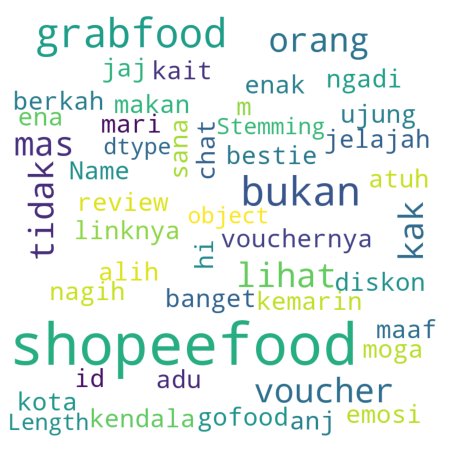

In [68]:
word_to_plot = df['Stemming'].copy()
word_to_plot_1 = word_to_plot.apply(lambda x: (x,negasi))

wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', max_words = 1000
                      , min_font_size = 20, collocations=False).generate(str(word_to_plot_1))

#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

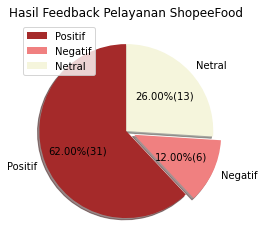

In [70]:
import matplotlib.pyplot as plt

values = [31, 6, 13]
explode = [0, 0.1, 0]
labels = ['Positif', 'Negatif', 'Netral']
colors = ['brown', 'lightcoral', 'beige']

def make_autopct(values):
    def my_autopct(pct):
        total  = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(values, colors=colors, labels=labels, explode=explode,
      autopct=make_autopct(values), shadow=True, startangle=90)
plt.legend()
plt.title("Hasil Feedback Pelayanan ShopeeFood")
plt.show()

In [1]:
In [ ]:
# some text to get the input
text = widgets.Textarea(placeholder="Enter your text here")
# checkboxes to select different levels of analysis
document_cb = widgets.Checkbox(value=True, description="Document Level")
sentence_cb = widgets.Checkbox(value=True, description="Sentence Level")
aspect_cb = widgets.Checkbox(value=True, description="Aspect Level")
opinion_cb = widgets.Checkbox(value=True, description="Opinion Level")

# some button to trigger the analysis
btn = widgets.Button(description="Analyse")

# some place to show the output on
out = widgets.Output()

def analysis(b):
    with out:
        out.clear_output()
        sentences = text.value # get the input sentences from the Textarea widget
        # pass the input sentences to our `sentiment_analysis_example` function
        sentiment_analysis_with_opinion_mining_example(sentences,
                                                       document_level=document_cb.value,
                                                       sentence_level=sentence_cb.value,
                                                       aspect_level=aspect_cb.value,
                                                       opinion_level=opinion_cb.value
                                                      )

btn.on_click(analysis) # bind the button with the `sentiment_analysis` function

# put all widgets together in a tool
checkboxes = widgets.VBox([document_cb, sentence_cb, aspect_cb,opinion_cb])
tool = widgets.VBox([widgets.HBox([text, checkboxes]), btn, out]) 
# give a default value for the text
text.value = "The food and service were unacceptable and meh, but the concierge were nice and ok"
tool

SyntaxError: invalid syntax (Temp/ipykernel_12076/2753654903.py, line 1)